## An introduction to Iris

In [1]:
import iris
import numpy as np

In [2]:
print(iris.__version__)
print(np.__version__)

1.10.0
1.11.2


### Discuss ###

What is Iris?

## Iris and the cube

The top level object in Iris is called a cube. A cube contains data and metadata about a single phenomenon and is an implementation of the data model interpreted from the *Climate and Forecast (CF) Metadata Conventions*.

Each cube has:

 * A data array (typically a NumPy array).
 * A "name", preferably a CF "standard name" to describe the phenomenon that the cube represents.
 * A collection of coordinates to describe each of the dimensions of the data array. These coordinates are split into two types:
    * Dimensioned coordinates are numeric, monotonic and represent a single dimension of the data array. There may be only one dimensioned coordinate per data dimension.
    * Auxilliary coordinates can be of any type, including discrete values such as strings, and may represent more than one data dimension.

A fuller explanation is available in the [Iris user guide](http://scitools.org.uk/iris/docs/latest/userguide/iris_cubes.html).

Let's take a simple example to demonstrate the cube concept.

Suppose we have a ``(3, 2, 4)`` NumPy array:

![](../images/multi_array.png)


Where dimensions 0, 1, and 2 have lengths 3, 2 and 4 respectively.

The Iris cube to represent this data may consist of:

 * a standard name of "air_temperature" and units of "kelvin"

 * a data array of shape ``(3, 2, 4)``

 * a coordinate, mapping to dimension 0, consisting of:
     * a standard name of "height" and units of "meters"
     * an array of length 3 representing the 3 height points
     
 * a coordinate, mapping to dimension 1, consisting of:
     * a standard name of "latitude" and units of "degrees"
     * an array of length 2 representing the 2 latitude points
     * a coordinate system such that the latitude points could be fully located on the globe
     
 * a coordinate, mapping to dimension 2, consisting of:
     * a standard name of "longitude" and units of "degrees"
     * an array of length 4 representing the 4 longitude points
     * a coordinate system such that the longitude points could be fully located on the globe

Pictorially the cube has taken on more information than a simple array:

![](../images/multi_array_to_cube.png)

## Working with a cube

Whilst it is possible to construct a cube by hand, a far more common approach to getting hold of a cube is to use the Iris load function to access data that already exists in a file.

In [3]:
fname = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(fname)
print(cubes)

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
1: surface_altitude / (m)              (grid_latitude: 204; grid_longitude: 187)


We can see that we've loaded two cubes, one representing the "surface_altitude" and the other representing "air_potential_temperature". We can infer even more detail from this printout; for example, what are the dimensions and shape of the "air_potential_temperature" cube?

Above we've printed the ``iris.cube.CubeList`` instance representing all of the cubes found in the given filename. However, we can see more detail by printing individual cubes:

In [4]:
air_pot_temp = cubes[0]
print(air_pot_temp)

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                      -                 -                    -
          model_level_number             -                      x                 -                    -
          grid_latitude                  -                      -                 x                    -
          grid_longitude                 -                      -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                      -                 -                    -
          level_height                   -                      x                 -                    -
          sigma                          -                      x                 -                    -
          surface_altitude               -                      -                 x                

We can dig even deeper and print individual coordinates:

In [5]:
print(air_pot_temp.coord('model_level_number'))

DimCoord(array([ 1,  4,  7, 10, 13, 16, 19], dtype=int32), standard_name='model_level_number', units=Unit('1'), attributes={'positive': 'up'})


## Cube attributes

In [6]:
cube = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
print(cube)

air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


To access a cube's data array the ``data`` property exists. This is either a NumPy array or in some cases a NumPy masked array. It is very important to note that for most of the supported filetypes in Iris, the cube's data isn't actually loaded until you request it via this property (either directly or indirectly). After you've accessed the data once, it is stored on the cube and thus won't be loaded from disk again.

To find the shape of a cube's data it is possible to call ``cube.data.shape`` or ``cube.data.ndim``, but this will trigger any unloaded data to be loaded. Therefore ``shape`` and ``ndim`` are properties available directly on the cube that do not unnecessarily load data.

In [7]:
print(cube.shape)
print(cube.ndim)
print(type(cube.data))

(240, 37, 49)
3
<class 'numpy.ndarray'>


The ``standard_name``, ``long_name`` and to an extent ``var_name`` are all attributes to describe the phenomenon that the cube represents. The ``name()`` method is a convenience that looks at the name attributes in the order they are listed above, returning the first non-empty string. To rename a cube, it is possible to set the attributes manually, but it is generally easier to use the ``rename()`` method.


In [8]:
print(cube.standard_name)
print(cube.long_name)
print(cube.var_name)
print(cube.name())

air_temperature
None
air_temperature
air_temperature


In [9]:
cube.rename("A name that isn't a valid CF standard name")

In [10]:
print(cube.standard_name)
print(cube.long_name)
print(cube.var_name)
print(cube.name())

None
A name that isn't a valid CF standard name
None
A name that isn't a valid CF standard name


The ``units`` attribute on a cube tells us the units of the numbers held in the data array. We can manually change the units, or better, we can convert the cube to another unit using the ``convert_units`` method, which will automatically update the data array.

In [11]:
print(cube.units)
print(cube.data.max())
cube.convert_units('Celsius')
print(cube.units)
print(cube.data.max())

K
306.073
Celsius
32.9233


A cube has a dictionary for extra general purpose attributes, which can be accessed with the ``cube.attributes`` attribute:

In [12]:
print(cube.attributes)
print(cube.attributes['STASH'])

{'source': 'Data from Met Office Unified Model 6.05', 'STASH': STASH(model=1, section=3, item=236), 'Model scenario': 'A1B', 'Conventions': 'CF-1.5'}
m01s03i236


A less frequently used attribute on a cube is its ``cell_methods``. The cell methods are a way to store information about the processing that has taken place on the cube.

In [13]:
for cell_method in cube.cell_methods:
    print(cell_method)

mean: time (6 hour)


In this case we can see that the cube is has been produced by taking a mean of forecasts sampled at 6 hourly intervals (we need to look at the time coordinate to identify any more information).

## Coordinates

As we've seen, cubes need coordinate information to help us describe the underlying phenomenon. Typically a cube's coordinates are accessed with the ``coords`` or ``coord`` methods. The latter *must* return exactly one coordinate for the given parameter filters, where the former returns a list of matching coordinates, possibly of length 0.

For example, to access the time coordinate, and print the first 4 times:

In [14]:
time = cube.coord('time')
print(time[:4])

DimCoord([1860-06-01 00:00:00, 1861-06-01 00:00:00, 1862-06-01 00:00:00,
       1863-06-01 00:00:00], bounds=[[1859-12-01 00:00:00, 1860-12-01 00:00:00],
       [1860-12-01 00:00:00, 1861-12-01 00:00:00],
       [1861-12-01 00:00:00, 1862-12-01 00:00:00],
       [1862-12-01 00:00:00, 1863-12-01 00:00:00]], standard_name='time', calendar='360_day', var_name='time')


Along with the cell method from the previous section, we can now see that this cube represents the mean annual air temperature, sampled every 6 hours, starting in 1860.

The coordinate interface is very similar to that of a cube. The attributes that exist on both cubes and coordinates are: ``standard_name``, ``long_name``, ``var_name``, ``units``, ``attributes`` and ``shape``. Similarly, the ``name()``, ``rename()`` and ``convert_units()`` methods also exist on a coordinate.

A coordinate does not have ``data``, instead it has ``points`` and ``bounds`` (``bounds`` may be ``None``). In Iris, time coordinates are currently represented as "a number since an epoch":

In [15]:
print(repr(time.units))
print(time.points[:4])
print(time.bounds[:4])

Unit('hours since 1970-01-01 00:00:00', calendar='360_day')
[-946800. -938160. -929520. -920880.]
[[-951120. -942480.]
 [-942480. -933840.]
 [-933840. -925200.]
 [-925200. -916560.]]


These numbers can be converted to datetime objects with the unit's ``num2date`` method. Dates can be converted back again with the ``date2num`` method:

In [16]:
import datetime

print(time.units.num2date(time.points[:4]))
print(time.units.date2num(datetime.datetime(1970, 2, 1)))

[1860-06-01 00:00:00 1861-06-01 00:00:00 1862-06-01 00:00:00
 1863-06-01 00:00:00]
720.0


Another important attribute on a coordinate is its coordinate system. Coordinate systems may be ``None`` for trivial coordinates, but particularly for spatial coordinates, they may be complex definitions of things such as the projection, ellipse and/or datum.

In [17]:
lat = cube.coord('latitude')
print(lat.coord_system)

GeogCS(6371229.0)


In this case, the latitude's coordinate system is a simple geographic latitude on a spherical globe of radius 6371229 (meters).

Sometimes it is desirable to add bounds to a coordinate that doesn't have any. This is often the case for creating "block" type plots where a coordinate should be able to represent an interval of values, rather than a single point. The ``guess_bounds`` method on a coordinate is useful in this regard. For example, the latitude coordinate previously obtained does not have bounds, but we can either set some manually, or use the ``guess_bounds`` method:

In [18]:
print(lat.points[:4])
print(lat.bounds)
if lat.bounds is None:
    lat.guess_bounds()
print(lat.bounds[:4])

[ 15.    16.25  17.5   18.75]
None
[[ 14.375  15.625]
 [ 15.625  16.875]
 [ 16.875  18.125]
 [ 18.125  19.375]]


### Exercise 1

1\. Using the file in ``iris.sample_data_path('atlantic_profiles.nc')`` load the data and print the cube list. Store these cubes in a variable called cubes.

2\. Loop through each of the cubes (e.g. ``for cube in cubes``) and print the standard name of each.

3\. Extract the "sea_water_potential_temperature" cube. Print the minimum, maximum, mean and standard deviation of the cube's data.

4\. Print the attributes of the cube.

5\. Print the names of all coordinates on the cube. (Hint: Remember the cube.coords method without any keywords will give us all of the cube's coordinates)

6\. Get hold of the "latitude" coordinate on the cube. Identify whether this coordinate has bounds. Print the minimum and maximum latitude points in the cube.

## Loading data into Iris

We've already seen the basic ``load`` function, but we can also control which cubes are actually loaded with *constraints*. The simplest constraint is just a string, which filters cubes based on their name:

In [19]:
fname = iris.sample_data_path('uk_hires.pp')
print(iris.load(fname, 'air_potential_temperature'))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


#### Note on sample_data_path:

Throughout this course we will make use of the sample data that Iris provides. The function ``iris.sample_data_path`` returns the appropriate path to the file in the Iris sample data collection. A common mistake for Iris users is to use the ``sample_data_path`` function to access data that is not part of Iris's sample data collection - this is bad practice and is unlikely to work in the future.

### Exercise 2

Print the result of ``iris.sample_data_path('uk_hires.pp')`` to verify that it returns a string pointing to a file on your system. Use this string directly in the call to ``iris.load`` and confirm the result is the same as in the previous example e.g.:

    print iris.load('/path/to/iris/sampledata/uk_hires.pp', 'air_potential_temperature')

### The three load functions: load, load_cube and load_cubes

There are three main load functions in Iris: ``load``, ``load_cube`` and ``load_cubes``.

1. **load** is a general purpose loading function. Typically this is where all data analysis will start, before more loading is refined with the more controlled loading from the other two functions.
2. **load_cube** returns a single cube from the given source(s) and constraint. There will be exactly one cube, or an exception will be raised.
3. **load_cubes** returns a list of cubes from the given sources(s) and constraint(s). There will be exactly one cube per constraint, or an exception will be raised.


Note: ``load_cube`` is a special case of ``load_cubes``, which can be seen with:

In [20]:
c1, = iris.load(fname, 'surface_altitude')
c2 = iris.load_cube(fname, 'surface_altitude')
c3, = iris.load_cubes(fname, 'surface_altitude')
c1 == c2 == c3

True

In general, it is a good idea to make use of the ``load_cube``/``load_cubes`` functions rather than the generic ``load`` function in non-exploratory code. Doing so makes your code more resilient to changes in the data source, often results in more readable/maintainable code, and in combination with well defined constraints, often leads to improve load performance.

The load functions all accept a list of filenames to load, and any of the filenames can be "glob" patterns (http://docs.python.org/2/library/glob.html).

### Exercise 2 (continued)

Read in the files found at **``iris.sample_data_path('GloSea4', 'ensemble_010.pp')``** and
**``iris.sample_data_path('GloSea4', 'ensemble_011.pp')``** using a single load call. Do this by:

1\. providing a list of the two filenames.

2\. providing a suitable glob pattern. (Notice that **``iris.load(iris.sample_data_path('GloSea4', 'ensemble_01*.pp'))``** picks up too many files.)

## Constraints

Iris's constraints mechanism provides a powerful way to filter a subset of data from a larger collection. We've already seen that constraints can be used at load time to return data of interest from a file, but we can also apply constraints to a single cube, or a list of cubes, using their respective ``extract`` methods:



In [21]:
fname = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(fname)
print(cubes.extract('air_potential_temperature'))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


The simplest constraint, namely a string that matches a cube's name, is conveniently converted into an actual ``iris.Constraint`` instance wherever needed. However, we could construct this constraint manually and compare with the previous result:

In [22]:
pot_temperature_constraint = iris.Constraint('air_potential_temperature')
print(cubes.extract(pot_temperature_constraint))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


The Constraint constructor also takes arbitrary keywords to constrain coordinate values. For example, to extract model level number 10 from the air potential temperature cube:

In [23]:
pot_temperature_constraint = iris.Constraint('air_potential_temperature',
                                             model_level_number=10)
print(cubes.extract(pot_temperature_constraint))

0: air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)


We can pass a list of possible values, and even combine two constraints with ``&``:

In [24]:
print(cubes.extract('air_potential_temperature' & 
                    iris.Constraint(model_level_number=[4, 10])))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 2; grid_latitude: 204; grid_longitude: 187)


We can define arbitrary functions that operate on each cell of a coordinate. This is a common thing to do for floating point coordinates, where exact equality is non-trivial.

In [25]:
def less_than_10(cell):
    """Return True for values that are less than 10."""
    return cell < 10

print(cubes.extract(iris.Constraint('air_potential_temperature',
                                    model_level_number=less_than_10)))

0: air_potential_temperature / (K)     (time: 3; model_level_number: 3; grid_latitude: 204; grid_longitude: 187)


Because Iris cells represent both point and bound, cell comparison can sometimes be counter-intuitive:

In [26]:
def cell_comparison(cell, value):
    print('cell > {0!r} is {1}'.format(value, cell > value))
    print('cell >= {0!r} is {1}'.format(value, cell >= value))
    print('cell == {0!r} is {1}'.format(value, cell == value))
    print('cell <= {0!r} is {1}'.format(value, cell <= value))
    print('cell < {0!r} is {1}'.format(value, cell < value))

cell = iris.coords.Cell(point=10, bound=[8, 12])
cell_comparison(cell, 12)

cell > 12 is False
cell >= 12 is True
cell == 12 is True
cell <= 12 is True
cell < 12 is False


If you want full control of how cell comparison is taking place, you can always compare with another cell, or just access the cell's individual ``point`` or ``bound``:

In [27]:
cell_1 = iris.coords.Cell(point=10, bound=[8, 12])
cell_2 = iris.coords.Cell(point=11, bound=None)

cell_comparison(cell_1, 11)
print()
cell_comparison(cell_1, cell_2)

cell > 11 is False
cell >= 11 is True
cell == 11 is True
cell <= 11 is True
cell < 11 is False

cell > Cell(point=11, bound=None) is False
cell >= Cell(point=11, bound=None) is False
cell == Cell(point=11, bound=None) is False
cell <= Cell(point=11, bound=None) is True
cell < Cell(point=11, bound=None) is True


It is common to want to build a constraint for time. With Iris < v1.6 it was harder to build time constraints than we would have liked, because of the way that time coordinates had been implemented.

However, since v1.6 this has been made simpler through the ability to compare against cells containing datetimes. The functionality can be enabled globally within the session (and will be enabled by default in future release of Iris) with:

In [28]:
iris.FUTURE.cell_datetime_objects = True

With this set, it is now possible to do the same constraint by simply:

In [29]:
time_constraint = iris.Constraint(
    time=lambda c: c >= datetime.datetime(2009, 11, 19, 11, 0))
print(air_pot_temp.extract(time_constraint).summary(True))

air_potential_temperature / (K)     (time: 2; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


There are currently still some limitations however. For example, it is not yet possible to do cell based datetime comparisons when the datetime is from anything other than a Gregorian calendar (e.g. such as the 360-day calendar often used in climate models). When this is the case however, we can always access individual components of the datetime and do comparisons on those:

In [30]:
time_constraint = iris.Constraint(time=lambda c: c.point.hour == 11)
print(air_pot_temp.extract(time_constraint).summary(True))

air_potential_temperature / (K)     (model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


Further functionality has been added to isolate individual components of a datetime via the [PartialDateTime](http://scitools.org.uk/iris/docs/latest/iris/iris/time.html?highlight=partial#iris.time.PartialDateTime) class. In this case we can extract the timestep at the 11th hour with:

In [31]:
from iris.time import PartialDateTime
eleventh_hour = iris.Constraint(time=PartialDateTime(hour=11))
print(air_pot_temp.extract(eleventh_hour).summary(True))
print(air_pot_temp.extract(eleventh_hour).coord('time'))

air_potential_temperature / (K)     (model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
DimCoord([2009-11-19 11:00:00], standard_name='time', calendar='gregorian')


### Exercise 3

The following function tells us whether or not a cube has cell methods:

    def has_cell_methods(cube):
        return len(cube.cell_methods) > 0

1\. With the cubes loaded from ``[iris.sample_data_path('A1B_north_america.nc'), iris.sample_data_path('uk_hires.pp')]`` use the CubeList's **``extract``** method to filter only the cubes that have cell methods. (Hint: Look at the ``iris.Constraint`` documentation for the **cube_func** keyword). You should find that the 3 cubes are whittled down to just 1.

2\. Using the file found at ``iris.sample_data_path('A1B_north_america.nc')`` filter the cube, using constraints, such that only data between 1860 and 1980 remains (hint: This data has a 360-day calendar with yearly data from 1860 to 2100, so we will need to access the individual components of the cell point's datetime, to return a time dimension of length 120).

## Saving cubes

The ``iris.save`` function provides a convenient interface to save Cube and CubeList instances.

To save some cubes to a NetCDF file:

In [32]:
fname = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(fname)
iris.save(cubes, 'saved_cubes.nc')

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/netcdf.py:2094: IrisDeprecation: NetCDF default saving behaviour currently assigns the outermost dimensions to unlimited. This behaviour is to be deprecated, in favour of no automatic assignment. To switch to the new behaviour, set iris.FUTURE.netcdf_no_unlimited to True.
  warn_deprecated(msg)


In [33]:
!ncdump -h saved_cubes.nc | head -n 20
!rm saved_cubes.nc

/bin/sh: ncdump: command not found


Extra keywords can be passed to specific fileformat savers.

**Task:** Go to the Iris reference documentation for ``iris.save``. What fileformats can Iris currently save to? What keywords are accepted to ``iris.save`` when saving a PP file?

## Indexing

Cubes can be indexed in a familiar manner to that of NumPy arrays:

In [34]:
fname = iris.sample_data_path('uk_hires.pp')
cube = iris.load_cube(fname, 'air_potential_temperature')
print(cube.summary(shorten=True))

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


In [35]:
subcube = cube[..., ::2, 15:35, :10]
subcube.summary(shorten=True)

'air_potential_temperature / (K)     (time: 3; model_level_number: 4; grid_latitude: 20; grid_longitude: 10)'

Note: the result of indexing a cube is *always* a copy and never a *view* on the original data.

## Merging

When Iris loads data it tries to reduce the number of cubes returned by collecting together multiple fields with
shared metadata into a single multidimensional cube. In Iris, this is known as merging.

In order to merge two cubes, they must be identical in everything but a scalar dimension, which goes on to become a new data dimension.

The ``iris.load_raw`` function can be used as a diagnostic tool to identify the individual "fields" that Iris identifies in a given set of filenames before any merge takes place:

In [36]:
fname = iris.sample_data_path('GloSea4', 'ensemble_008.pp')
raw_cubes = iris.load_raw(fname)

print(len(raw_cubes))

6


When we look in detail at these cubes, we find that they are identical in every coordinate except for the scalar forecast_period and time coordinates:

In [37]:
print(raw_cubes[0])
print()
print(raw_cubes[1])

surface_temperature / (K)           (latitude: 145; longitude: 192)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          forecast_period: 612.0 hours, bound=(240.0, 984.0) hours
          forecast_reference_time: 2011-07-22 00:00:00
          realization: 8
          time: 2011-08-16 12:00:00, bound=(2011-08-01 00:00:00, 2011-09-01 00:00:00)
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 7.6
     Cell methods:
          mean: time (1 hour)

surface_temperature / (K)           (latitude: 145; longitude: 192)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          forecast_period: 1344.0 hours, bound=(984.0, 1704.0) hours
          forecast_reference_t

Any CubeList can be merged with the ``merge`` method, and the resulting CubeList from load_raw is no different.
The ``merge`` method *always* returns another CubeList:

In [38]:
merged_cube, = raw_cubes.merge()
print(merged_cube)

surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -            x               -
          longitude                      -            -               x
     Auxiliary coordinates:
          forecast_period                x            -               -
     Scalar coordinates:
          forecast_reference_time: 2011-07-22 00:00:00
          realization: 8
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 7.6
     Cell methods:
          mean: time (1 hour)


When we look in more detail, we can see that the time coordinate has become a new dimension, as well as gaining another forecast_period auxiliary coordinate:

In [39]:
print(merged_cube.coord('time'))
print(merged_cube.coord('forecast_period'))

DimCoord([2011-08-16 12:00:00, 2011-09-16 00:00:00, 2011-10-16 12:00:00,
       2011-11-16 00:00:00, 2011-12-16 12:00:00, 2012-01-16 12:00:00], bounds=[[2011-08-01 00:00:00, 2011-09-01 00:00:00],
       [2011-09-01 00:00:00, 2011-10-01 00:00:00],
       [2011-10-01 00:00:00, 2011-11-01 00:00:00],
       [2011-11-01 00:00:00, 2011-12-01 00:00:00],
       [2011-12-01 00:00:00, 2012-01-01 00:00:00],
       [2012-01-01 00:00:00, 2012-02-01 00:00:00]], standard_name='time', calendar='gregorian')
DimCoord(array([  612.,  1344.,  2076.,  2808.,  3540.,  4284.]), bounds=array([[  240.,   984.],
       [  984.,  1704.],
       [ 1704.,  2448.],
       [ 2448.,  3168.],
       [ 3168.,  3912.],
       [ 3912.,  4656.]]), standard_name='forecast_period', units=Unit('hours'))


### Identifying merge problems

In order to avoid the Iris merge functionality making often inappropriate assumptions about incoming data, merge is strict with regards to the uniformity of the incoming cubes.

For example, if we load the fields from two ensemble members from the GloSea4 model sample data, we see we have 12 fields before any merge takes place:

In [40]:
fname = iris.sample_data_path('GloSea4', 'ensemble_00[34].pp')
cubes = iris.load_raw(fname, 'surface_temperature')
print(len(cubes))

12


If we try to merge these 12 cubes we get 2 cubes rather than one:

In [41]:
incomplete_cubes = cubes.merge(unique=False)
print(incomplete_cubes)

0: surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
1: surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)


When we look in more detail at these two cubes, what is different between the two? (Hint: One value changes, another is completely missing)

In [42]:
print(incomplete_cubes[0])
print('--' * 50)
print(incomplete_cubes[1])

surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -            x               -
          longitude                      -            -               x
     Auxiliary coordinates:
          forecast_period                x            -               -
     Scalar coordinates:
          forecast_reference_time: 2011-07-19 00:00:00
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 7.6
     Cell methods:
          mean: time (1 hour)
----------------------------------------------------------------------------------------------------
surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -      

By adding the missing coordinate, we can trigger a merge of the 12 cubes into a single cube, as expected:

In [43]:
for cube in cubes:
    if not cube.coords('realization'):
        cube.add_aux_coord(iris.coords.DimCoord(np.int32(3),
                                                'realization'))

merged_cubes = cubes.merge()
print(merged_cubes)

0: surface_temperature / (K)           (time: 6; forecast_reference_time: 2; latitude: 145; longitude: 192)


Iris v1.7 and beyond includes functionality to simplify the identification process for causes of failed merges. The ``merge_cube`` method of a CubeList expects the list of cubes to contain only cubes that can be merged to produce a single cube. If they do not merge to a single cube, a descriptive exception will be raised. For instance:

```
   >>> cubes.merge_cube()
   Traceback (most recent call last):
     File "<stdin>", line 1, in <module>
     ...
   iris.exceptions.MergeError: failed to merge into a single cube.
     Coordinates in cube.aux_coords (scalar) differ: realization.
```

### Exercise 4

The following exercise is designed to give you experience of solving issues that prevent a merge from taking place.
The output from ``merge_cube`` is included to help with identification, and once a fix has been identified, ``raw_cubes.merge()`` should result in a CubeList containing a single cube:

The first exercise is completed below:

1\. Identify and resolve the issue preventing ``resources/merge_exercise.1.*.nc`` from merging.

    >>> raw_cubes = iris.load_raw('../resources/merge_exercise.1.*.nc')
    >>> raw_cubes.merge_cube()
    Traceback (most recent call last):
    ...
    iris.exceptions.MergeError: failed to merge into a single cube.
      cube.attributes keys differ: 'History'


In [44]:
raw_cubes = iris.load_raw('../resources/merge_exercise.1.*.nc')

# Print the attributes, clearly one is different.
for cube in raw_cubes:
    print(cube.attributes)

# Remove the history attribute from the first cube.
del raw_cubes[0].attributes['History']

# Check that this has meant that a merge now results in a single cube.
print(raw_cubes.merge())

{'source': 'Iris test case', 'History': 'unknown', 'Conventions': 'CF-1.5'}
{'source': 'Iris test case', 'Conventions': 'CF-1.5'}
0: air_potential_temperature / (K)     (time: 2; grid_latitude: 100; grid_longitude: 100)


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


2\. Identify and resolve the issue preventing ``resources/merge_exercise.2.*.nc`` from merging.

    >>> raw_cubes = iris.load_raw('../resources/merge_exercise.2.*.nc')
    >>> raw_cubes.merge_cube()
    Traceback (most recent call last):
      iris.exceptions.MergeError: failed to merge into a single cube.
      cube.long_name differs: u'The first timestep' != u'The second timestep'

3\. (extension) Identify and resolve the issue preventing ``resources/merge_exercise.4.*.nc`` from merging.

    >>> raw_cubes = iris.load_raw('../resources/merge_exercise.4.*.nc')
    >>> raw_cubes.merge_cube()
    Traceback (most recent call last):
      iris.exceptions.MergeError: failed to merge into a single cube.
      cube data dtype differs: float32 != float64

4\. (extension) Identify and resolve the issue preventing ``resources/merge_exercise.5.*.nc`` from merging (hint: Cubes can be indexed like NumPy arrays).

    >>> raw_cubes = iris.load_raw('../resources/merge_exercise.5.*.nc')
    >>> raw_cubes.merge_cube()
    Traceback (most recent call last):
      iris.exceptions.MergeError: failed to merge into a single cube.
      cube.shape differs: (100, 100) != (1, 100, 100)

### Concatenate ###

We have seen that merge combines a list of cubes with a common scalar coordinate to produce a single cube with a new dimension created from these scalar values.

But what happens if you try to combine cubes along a common dimension?

In [45]:
fname = iris.sample_data_path('A1B_north_america.nc')
cube = iris.load_cube(fname)

cube_1 = cube[:10]
cube_2 = cube[10:20]
cubes = iris.cube.CubeList([cube_1, cube_2])
print(cubes)

0: air_temperature / (K)               (time: 10; latitude: 37; longitude: 49)
1: air_temperature / (K)               (time: 10; latitude: 37; longitude: 49)


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


These cubes should be able to be merged; after all, they have both come from the same original cube!

In [46]:
print(cubes.merge())

0: air_temperature / (K)               (time: 10; latitude: 37; longitude: 49)
1: air_temperature / (K)               (time: 10; latitude: 37; longitude: 49)


Merge cannot be used to combine common non-scalar coordinates. Instead we must use concatenate, which joins together ("concatenates") common non-scalar coordinates to produce a single cube with the common dimension extended:

In [47]:
print(cubes.concatenate())

0: air_temperature / (K)               (time: 20; latitude: 37; longitude: 49)


As with merge, Iris contains functionality to simplify the identification process for causes of failed concatenations. The ``concatenate_cube`` method of a CubeList expects the list of cubes to contain only cubes that can be concatenated to produce a single cube. If they do not concatenate to a single cube, a descriptive error will be raised. For instance:

```
    >>> print cubes.concatenate_cube()
    Traceback (most recent call last):
      ...
    iris.exceptions.ConcatenateError: failed to concatenate into a single cube.
      Scalar coordinates differ: forecast_reference_time, height != forecast_reference_time
```

## Load callbacks

Sometimes important data exists in a filename rather than in the file itself, and it is desirable for it to become part of the cube's metadata.
For example, some early GloSea4 model runs recorded the "ensemble member number" (or "realization" in CF terms) in the filename, but not in actual PP metadata itself. As a result, loading the data yielded 2 cubes, rather than a single, fully merged, cube.

In [48]:
fname = iris.sample_data_path('GloSea4', 'ensemble_00[34].pp')
for cube in iris.load(fname, 'surface_temperature'):
    print(cube, '\n-----')

surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -            x               -
          longitude                      -            -               x
     Auxiliary coordinates:
          forecast_period                x            -               -
     Scalar coordinates:
          forecast_reference_time: 2011-07-19 00:00:00
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 7.6
     Cell methods:
          mean: time (1 hour) 
-----
surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -            x               -
          longitude                      -            -               

To resolve this we can define a function that gets called during the load process. This must take as arguments:

 * a cube,
 * a 2D field - either a PP field, a NetCDF variable or a GRIB message depending on the file format being loaded, and
 * a filename.

In this case, the function makes the necessary adjustments to include a "realization" coordinate. We pass this function to load, and the result is a successfully merged cube:

In [49]:
import os
def realization_callback(cube, field, fname):
    basename = os.path.basename(fname)
    if not cube.coords('realization') and basename.startswith('ensemble_'):
        cube.add_aux_coord(iris.coords.DimCoord(np.int32(basename[-6:-3]),
                                                'realization'))

print(iris.load_cube(fname, callback=realization_callback))

surface_temperature / (K)           (time: 6; forecast_reference_time: 2; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x                           -            -               -
          forecast_reference_time        -                           x            -               -
          latitude                       -                           -            x               -
          longitude                      -                           -            -               x
     Auxiliary coordinates:
          forecast_period                x                           x            -               -
          realization                    x                           x            -               -
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 7.6
     Cell methods:
          mean: time (1 hour)


## Cube aggregation/collapsing

Many standard univariate aggregations exist in Iris (and it is relatively easy to create your own, if the one you want doesn't exist).

In [50]:
fname = iris.sample_data_path('uk_hires.pp')
cube = iris.load_cube(fname, 'air_potential_temperature')
print(cube.summary(True))

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)


To take the vertical mean of this cube:

In [51]:
print(cube.collapsed('model_level_number', iris.analysis.MEAN))

air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                 -                    -
          grid_latitude                  -                 x                    -
          grid_longitude                 -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                 -                    -
          surface_altitude               -                 x                    x
     Derived coordinates:
          altitude                       -                 x                    x
     Scalar coordinates:
          forecast_reference_time: 2009-11-19 04:00:00
          level_height: 696.667 m, bound=(0.0, 1393.33) m
          model_level_number: 10, bound=(1, 19)
          sigma: 0.92293, bound=(0.84586, 1.0)
     Attributes:
          STASH: m01s00i004
          source: Data from Met Office Unified Model
        

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'model_level_number'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'level_height'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sigma'.
  warnings.warn(msg.format(self.name()))


Some of the aggregators accept ``weights`` as a keyword. The supplied weights must have the same shape as the cube (there is currently no broadcasting being done) but there is an Iris utility function to make this easier:

In [52]:
weights = np.array([1, 1.1, 1, 1.4, 0.7, 1, 1])
weights = iris.util.broadcast_to_shape(weights, cube.shape, (1,))
print(cube.collapsed('model_level_number',
                     iris.analysis.MEAN, weights=weights).summary(True))

air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'model_level_number'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'level_height'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sigma'.
  warnings.warn(msg.format(self.name()))


For an area weighted mean there is a convenience function called ``area_weights`` in ``iris.analysis.cartography``. One of the requirements of this function is that the spatial coordinates have bounds (otherwise there would be no area to calculate):

In [53]:
import iris.analysis.cartography
if cube.coord('grid_latitude').bounds is None:
    cube.coord('grid_latitude').guess_bounds()
    cube.coord('grid_longitude').guess_bounds()

grid_areas = iris.analysis.cartography.area_weights(cube)

This can be passed to the collapsed method along with the two coordinates that we want to take the mean over:

In [54]:
area_avg = cube.collapsed(['grid_longitude', 'grid_latitude'],
                          iris.analysis.MEAN, weights=grid_areas)
print(area_avg)

air_potential_temperature / (K)     (time: 3; model_level_number: 7)
     Dimension coordinates:
          time                           x                      -
          model_level_number             -                      x
     Auxiliary coordinates:
          forecast_period                x                      -
          level_height                   -                      x
          sigma                          -                      x
     Derived coordinates:
          altitude                       -                      x
     Scalar coordinates:
          forecast_reference_time: 2009-11-19 04:00:00
          grid_latitude: 1.51455 degrees, bound=(0.13755, 2.89155) degrees
          grid_longitude: 358.749 degrees, bound=(357.487, 360.012) degrees
          surface_altitude: 399.625 m, bound=(-14.0, 813.25) m
     Attributes:
          STASH: m01s00i004
          source: Data from Met Office Unified Model
          um_version: 7.3
     Cell methods:
          mean: 

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:988: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'surface_altitude'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/cube.py:1103: UserWarning: Orography coordinate 'surface_altitude' has bounds. These will be disregarded.
  factory.update(old_coord, new_coord)


### Exercise 5 ###

1\. What other aggregators are available?

2\. Calculate the potential temperature variance with time for cube `area_avg` from above. Hint: We want to reduce the area averaged cube's vertical dimension, and end up with a cube of length 3. Print the data values of the resulting cube.

## Iteration

We can loop through all desired subcubes in a larger cube using the ``slices`` and ``slices_over`` methods.

In [55]:
fname = iris.sample_data_path('uk_hires.pp')
cube = iris.load_cube(fname,
                      iris.Constraint('air_potential_temperature',
                                      model_level_number=1))
print(cube.summary(True))

air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)


The ``slices`` method returns all the slices of a cube on the dimensions specified by the coordinates passed to the slices method.

So in this example, each grid_latitude / grid_longitude slice of the cube is returned:

In [56]:
for subcube in cube.slices(['grid_latitude', 'grid_longitude']):
    print(subcube.summary(shorten=True))

air_potential_temperature / (K)     (grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (grid_latitude: 204; grid_longitude: 187)


The ``iris.iterate.izip`` function extends this concept and allows us to loop through multiple cubes at the same time:

In [58]:
from iris.iterate import izip

iris.FUTURE.cell_datetime_objects = True

e1 = iris.load_cube(iris.sample_data_path('E1_north_america.nc'))
a1b = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))

for e1_slice, a1b_slice in izip(e1, a1b, coords=['latitude', 'longitude']):
    print(e1_slice.summary(True), e1_slice.coord('time').cell(0).point)
    print(a1b_slice.summary(True), a1b_slice.coord('time').cell(0).point)
    break

air_temperature / (K)               (latitude: 37; longitude: 49) 1860-06-01 00:00:00
air_temperature / (K)               (latitude: 37; longitude: 49) 1860-06-01 00:00:00


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In this example, one real use for this functionality would be to plot the ``e1`` cube next to the ``a1b`` cube for each timestep.

We can use ``slices_over`` to return one subcube for each coordinate value in a specified coordinate. This helps us when trying to retrieve all the slices along a given cube dimension.

For example, let's consider retrieving all the slices over the time dimension (i.e. each time step in its own cube with a scalar time coordinate) using ``slices``. As per the above example, to achieve this using ``slices`` we would have to specify all the cube's dimensions _except_ the time dimension.

Let's take a look at ``slices_over`` providing this functionality:

In [60]:
fname = iris.sample_data_path('uk_hires.pp')
cube = iris.load_cube(fname, 'air_potential_temperature')
for subcube in cube.slices_over('model_level_number'):
    print(subcube.summary(shorten=True))

air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)
air_potential_temperature / (K)     (time: 3; grid_latitude: 204; grid_longitude: 187)


## Plotting

Iris comes with two plotting modules called ``iris.plot`` and ``iris.quickplot`` that wrap some of the common matplotlib plotting functions such that cubes can be passed as input rather than the usual NumPy arrays. The two modules are very similar, with the primary difference being that ``quickplot`` will add extra information to the axes, such as:

 * a colorbar,
 * labels for the x and y axes, and
 * a title where possible.

In [61]:
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt

In [62]:
cube = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
ts = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
print(ts)

air_temperature / (K)               (time: 240)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
          latitude: 37.5 degrees, bound=(15.0, 60.0) degrees
          longitude: 270.0 degrees, bound=(225.0, 315.0) degrees
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)
          mean: latitude, longitude


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Col

In [63]:
iplt.plot(ts)
plt.show()

<IPython.core.display.Javascript object>

For comparison, lets plot the result of ``iplt.plot`` next to ``qplt.plot``:

In [64]:
plt.subplot(1, 2, 1)
iplt.plot(ts)

plt.subplot(1, 2, 2)
qplt.plot(ts)

plt.subplots_adjust(wspace=0.5)
plt.show()

Notice how the result of qplt has axis labels and a title; everything else about the axes is identical.

The plotting functions in Iris have strict rules on the dimensionality of the inputted cubes. For example, a 2d cube is needed in order to create a contour plot:

In [65]:
qplt.contourf(cube[:, 0, :])
plt.show()

ValueError: Expecting netcdftimes with an extra "calendar" attribute.

Additionally, we can control the x and y axis coordinates with the **coords** keyword:

In [66]:
zonal_variance = cube.collapsed('longitude', iris.analysis.VARIANCE)
qplt.contourf(zonal_variance,
              coords=['forecast_period', 'latitude'])
plt.title('Zonal variance in air temperature')
plt.show()

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


### Maps with cartopy

When the result of a plot operation is a map, Iris will automatically create an appropriate cartopy axes if one doesn't already exist.

We can use matplotlib's gca() to get hold of the automatically created cartopy axes:

<IPython.core.display.Javascript object>


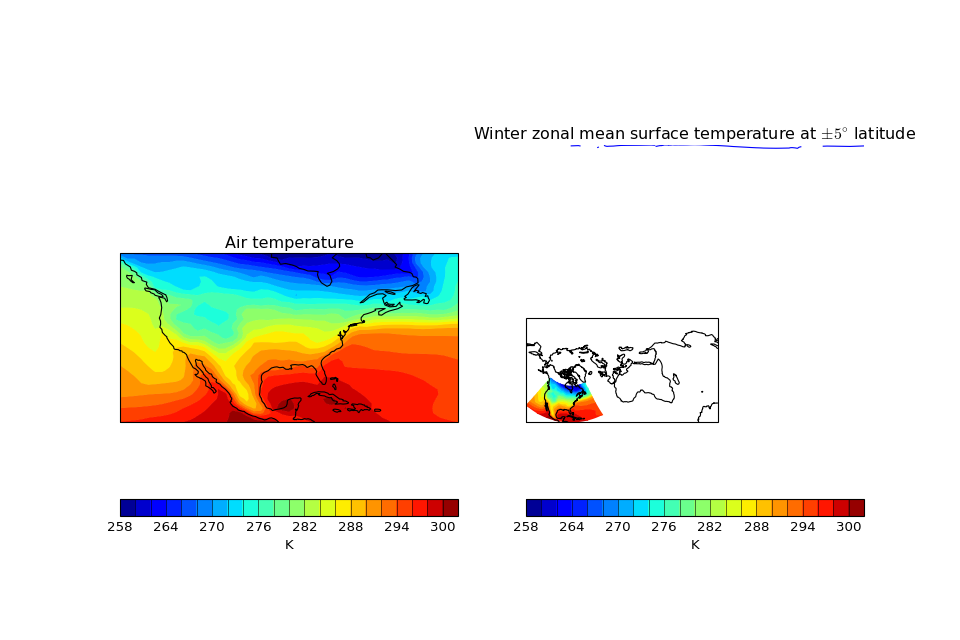

In [67]:
import cartopy.crs as ccrs

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
qplt.contourf(cube[0, ...], 25)
ax = plt.gca()
ax.coastlines()

ax = plt.subplot(1, 2, 2, projection=ccrs.RotatedPole(100, 37))
qplt.contourf(cube[0, ...], 25)
ax.coastlines()

plt.show()

### Exercise 6

Use the above cube with appropriate slicing, to produce the following:

1\. a **contour** plot of *time* vs *longitude*

2\. a **contourf** map on a LambertConformal projection (with coastlines)

3\. a block plot (**pcolormesh**) map in its native projection  (with coastlines)

4\. a line **plot** showing *air_temperature* vs *forecast_period* (hint: plot accepts two arguments for the x and y axes)

5\. a **scatter** plot showing *air_temperature* vs *longitude* (hint: the inputs to scatter can be a combination of coordinates or 1D cubes)

## Cube maths

Basic mathematical operators exist on the cube to allow one to add, subtract, divide, multiply and perform other mathematical operations on cubes of a similar shape to one another:

In [68]:
a1b = iris.load_cube(iris.sample_data_path('A1B_north_america.nc'))
e1 = iris.load_cube(iris.sample_data_path('E1_north_america.nc'))

print(e1.summary(True))
print(a1b)

air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
air_temperature / (K)               (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m
     Attributes:
          Conventions: CF-1.5
          Model scenario: A1B
          STASH: m01s03i236
          source: Data from Met Office Unified Model 6.05
     Cell methods:
          mean: time (6 hour)


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [69]:
scenario_difference = a1b - e1
print(scenario_difference)

unknown / (K)                       (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m


Notice that the resultant cube's name is now unknown and that the coordinates “time” and “forecast_period” have been removed; this is because these coordinates differed between the two input cubes.

It is also possible to operate on cubes with numeric scalars, NumPy arrays and even cube coordinates:

In [70]:
e1 * e1.coord('latitude')

<iris 'Cube' of unknown / (0.0174532925199433 kelvin-radian) (time: 240; latitude: 37; longitude: 49)>

Cube broadcasting is also taking place, meaning that the two cubes don't need to have the same shape:

In [71]:
print(e1 - e1.collapsed('time', iris.analysis.MEAN))

unknown / (K)                       (time: 240; latitude: 37; longitude: 49)
     Dimension coordinates:
          time                           x              -              -
          latitude                       -              x              -
          longitude                      -              -              x
     Auxiliary coordinates:
          forecast_period                x              -              -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 06:00:00
          height: 1.5 m


/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


Sometimes aggregations don't exist in Iris, so it is important that we still have the power to update the cube's data directly. Whenever we do this though, we should be mindful of updating the necessary metadata on the cube:

In [72]:
e1_hot = e1.copy()

e1_hot.data = np.ma.masked_less_equal(e1_hot.data, 280)
e1_hot.rename('air temperatures greater than 280K')

## Creating extra annotation coordinates for statistical convenience

Sometimes we want to be able to categorise data before performing statistical operations on it. For example, we might want to categorise our data by "daylight maximum" or "seasonal mean" etc. Both of these categorisations would be based on the time coordinate.

The ``iris.coord_categorisation`` module provides convenience functions to add some common categorical coordinates, and provides a generalised function to allow each creation of custom categorisations. 

In [73]:
import iris.coord_categorisation as coord_cat

filename = iris.sample_data_path('ostia_monthly.nc')
cube = iris.load_cube(filename, 'surface_temperature')

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


The cube loaded represents the monthly air_temperature from April 2006 through to October 2010. Let's add a categorisation coordinate to this cube to identify the climatological season (i.e "djf", "mam", "jja" or "son") of each time point:

In [74]:
coord_cat.add_season(cube, 'time', name='clim_season')

We can now use the cube's ``aggregated_by`` method to "group by and aggregate" on the season, to produce the seasonal mean:

In [75]:
seasonal_mean = cube.aggregated_by('clim_season', iris.analysis.MEAN)

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:495: VisibleDeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).
  bounds = bounds[keys + (Ellipsis, )]


We can take this further by extracting by our newly created coordinate, producing a plot of the winter zonal mean:

In [76]:
winter = seasonal_mean.extract(iris.Constraint(clim_season='djf'))

qplt.plot(winter.collapsed('latitude', iris.analysis.MEAN))
plt.title('Winter zonal mean surface temperature at $\pm5^{\circ}$ latitude')
plt.show()

/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/Users/watson-parris/anaconda/envs/cis_test/lib/python3.4/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


### Custom categorisation ###

Custom categorisation can be achieved with an arbitrary function. For example, the existing ``add_year`` categorisor takes the 'time' coordinate, and creates a 'year' coordinate. This could be achieved without using the available ``add_year`` by:

In [77]:
def year_from_time(coord, point):
    return coord.units.num2date(point).year

coord_cat.add_categorised_coord(cube, 'year', cube.coord('time'),
                                year_from_time)

print(cube.coord('year'))

AuxCoord(array([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2007, 2007,
       2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2008,
       2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
       2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009,
       2009, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010]), standard_name=None, units=Unit('1'), long_name='year')


## Performance tricks

This section details a few common tricks to improve the performance of your Iris code:

 * Data loading.
 * Load once, extract many times.

### Make use of deferred loading of data ###

Sometimes it makes sense to load data before doing operations, other times it makes sense to do data reduction before loading:

In [78]:
def zonal_sum(cube):
    """
    A really silly function to calculate the sum of the grid_longitude
    dimension.
    Don't use this in real life, instead consider doing:
    
        cube.collapsed('grid_longitude', iris.analysis.SUM)
    
    """
    total = 0
    for i, _ in enumerate(cube.coord('grid_longitude')):
        total += cube[..., i].data
    return total

In [79]:
%%timeit
fname = iris.sample_data_path('uk_hires.pp')
pt = iris.load_cube(fname, 'air_potential_temperature')
result = zonal_sum(pt)

1 loop, best of 3: 2.77 s per loop


The exact same code, only with the data loaded upfront:

In [80]:
%%timeit
fname = iris.sample_data_path('uk_hires.pp')
pt = iris.load_cube(fname, 'air_potential_temperature')
pt.data
result = zonal_sum(pt)

1 loop, best of 3: 713 ms per loop


### Load once, extract many times ###

Iris loading can be slow, particularly if the format stores 2d fields of a conceptually higher dimensional dataset, as is the case with GRIB and PP. To maximise load speed and avoid unncecessary processing, it is worth constraining the fields that are of interest *at load time*, but there is no caching, so loading a file twice will be twice as slow.

In [81]:
fname = iris.sample_data_path('uk_hires.pp')
model_levels = [1, 4, 7, 16]

In [82]:
%%timeit
for model_level in model_levels:
    pt = iris.load_cube(fname,
                        iris.Constraint('air_potential_temperature',
                                        model_level_number=model_level))

1 loop, best of 3: 214 ms per loop


In [83]:
%%timeit
cubes = iris.load(fname)
for model_level in model_levels:
    pt = cubes.extract(iris.Constraint('air_potential_temperature',
                                       model_level_number=model_level),
                       strict=True)

10 loops, best of 3: 109 ms per loop


For files with lots of different phenomenon this can be improved further by loading only the phenomenon (and in this case just the model levels of interest):

In [84]:
%%timeit
cube = iris.load(fname,
                 iris.Constraint('air_potential_temperature',
                                 model_level_number=model_levels))
for model_level in model_levels:
    pt = cube.extract(iris.Constraint(model_level_number=model_level))

10 loops, best of 3: 87.8 ms per loop


### Exercise 7

Produce a set of plots that provide a comparison of decadal-mean air temperatures over North America:

**Part 1**

Load 'A1B_north_america.nc' from the Iris sample data.

**Part 2**

Extract just data from the year 1980 and beyond from the loaded data.

**Part 3**

Define a function that takes a coordinate and a single time point as arguments, and returns the decade. For example, your function should return 2010 for the following:

       time = iris.coords.DimCoord([10], 'time',
                                   units='days since 2018-01-01')
       print your_decade_function(time, time.points[0])

**Part 4**

Add a "decade" coordinate to the loaded cube using your function and the coord categorisation module.

**Part 5**

Calculate the decadal means cube for this scenario.

**Part 6**

Create a figure with 3 rows and 4 columns displaying the decadal means, with the decade displayed prominently in each axes' title.